In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2019-07-22 00:15:10--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-07-22 00:15:10 (101 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


W0722 00:15:12.369858 140406950029184 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/keras/initializers.py:119: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 00:15:12.400454 140406950029184 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 00:15:12.407007 140406950029184 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be r

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [4]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

W0722 00:15:13.362025 140406950029184 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
15462/15462 [==============================] - 27s 2ms/sample - loss: 6.9013 - acc: 0.0215
Epoch 2/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.5052 - acc: 0.0218
Epoch 3/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.3827 - acc: 0.0261
Epoch 4/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.2656 - acc: 0.0279
Epoch 5/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.1781 - acc: 0.0338
Epoch 6/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.0963 - acc: 0.0396
Epoch 7/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.0158 - acc: 0.0416
Epoch 8/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 5.9346 - acc: 0.0430
Epoch 9/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 5.8425 - acc: 0.0484
Epoch 10/100
15462/15462 [==============================] - 25s 2ms/sampl

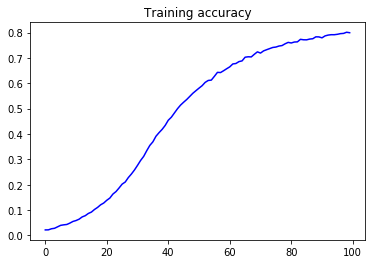

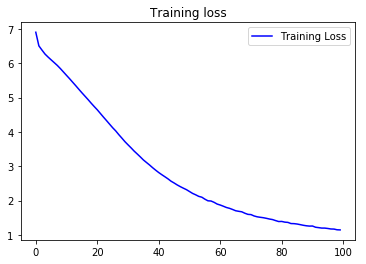

In [5]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [6]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope another time his help live new ' to ye ye blind bettering skill a date spring ' with live night to give bear kings begin car warm'd bow subscribes light burn'd outworn taken open rotten wantonness rage right state back new quite happy fled lies brought in thee new worth with loss with old worth live more and rare seen her same sky slain old thing dead last in thee die now strange ride days wide tend rotten scope can ride room burn'd new near forgot can free twain level new new new new fall with things ill ill ill
